In [8]:
from torch_snippets import transforms, Dataset, read, randint, nn, optim, DataLoader, Report, plt
#from torch_snippets import *
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import notebook
import cv2 as cv2
import torch 
from torchsummary import summary
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_PATH = "C:/Users/janop/Dropbox/Documents/Projects/GarbageProcessing/Reproduction of results/SpotGarbage Smartphone App to Detect Garbage Using Deep Learning/spotgarbage-GINI-master/spotgarbage/"

print(torch.cuda.device_count())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_device_properties(0))

1
(6, 1)
_CudaDeviceProperties(name='GeForce GTX 1050', major=6, minor=1, total_memory=4096MB, multi_processor_count=5)


In [2]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

Our Dataset overload is now a bit more sophisticated as it now implements k-fold stratified cross validation. Use sklearn for this

In [3]:
Splits = None
df_train = None
class pathchData(Dataset):
    def __init__(self, split, train_data, n_splits=5, aug=None):
        global Splits
        global df_train
        self.train_data  = train_data
        self.split       = split
        self.aug         = aug
        if Splits == None:
            splitter = StratifiedKFold(n_splits, shuffle=True, random_state=0)
            df_train = pd.read_csv(DATA_PATH + "train.csv", delimiter=",")
            Splits = []
            for train_idx, test_idx in splitter.split(df_train["name"], df_train["class"]):
                Splits.append((train_idx, test_idx))
            torch.save(Splits, DATA_PATH + "splits.pt")

    def __len__(self):
        return len(Splits[self.split][0]) if self.train_data else len(Splits[self.split][1])
    def __getitem__(self, ix):
        i = 0 if self.train_data else 1
        fullName = df_train["name"][Splits[self.split][i][ix]]
        garbageClass = df_train["class"][Splits[self.split][i][ix]]
        image = read(DATA_PATH + f"patches/{fullName}",1)
        image = cv2.resize(image, (227, 227))
        return image, 1 if garbageClass == "garbage" else 0
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, garbageClasses = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(DEVICE)
        garbageClasses = torch.tensor(garbageClasses).to(DEVICE)
        return ims, garbageClasses

In [4]:
alexnet = torch.hub.load("pytorch/vision:v0.9.0", "alexnet", pretrained=True).to(DEVICE)

for param in alexnet.parameters():
    param.requires_grad = False

alexnet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2),
        ).to(DEVICE)

summary(alexnet, (3,227,227));

Using cache found in C:\Users\janop/.cache\torch\hub\pytorch_vision_v0.9.0
C:\Users\janop\anaconda3\Lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 6, 6]           --
|    └─Conv2d: 2-1                       [-1, 64, 56, 56]          (23,296)
|    └─ReLU: 2-2                         [-1, 64, 56, 56]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 27, 27]          --
|    └─Conv2d: 2-4                       [-1, 192, 27, 27]         (307,392)
|    └─ReLU: 2-5                         [-1, 192, 27, 27]         --
|    └─MaxPool2d: 2-6                    [-1, 192, 13, 13]         --
|    └─Conv2d: 2-7                       [-1, 384, 13, 13]         (663,936)
|    └─ReLU: 2-8                         [-1, 384, 13, 13]         --
|    └─Conv2d: 2-9                       [-1, 256, 13, 13]         (884,992)
|    └─ReLU: 2-10                        [-1, 256, 13, 13]         --
|    └─Conv2d: 2-11                      [-1, 256, 13, 13]         (590,080)
|    └─ReLU: 2-12                        [-1, 256, 

And now for the training loop

In [5]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    im, garbClass = data
    out  = model(im)
    optimizer.zero_grad()
    loss = criterion(out, garbClass)
    acc = (torch.max(out,1)[1] == garbClass).float().mean()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

In [6]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    im, garbClass = data
    out = model(im)
    loss = criterion(out, garbClass)
    acc = (torch.max(out,1)[1] == garbClass).float().mean()
    return loss.item(), acc.item()

In [9]:
optimizer = optim.SGD(alexnet.parameters(), lr=1e-3, momentum=0.9, weight_decay=5*1e-5)
#criterion =  nn.BCELoss()# binary cross entropy loss
criterion = nn.CrossEntropyLoss()
n_epochs = 12 # 12
N_folds = 5 # 5
trn_ds = [pathchData(x, True) for x in range(N_folds)]
val_ds = [pathchData(x, False) for x in range(N_folds)]
trn_dl = [DataLoader(x, batch_size=100, shuffle=True, collate_fn=x.collate_fn) for x in trn_ds]
val_dl = [DataLoader(x, batch_size=100, shuffle=True, collate_fn=x.collate_fn) for x in val_ds]
log = Report(n_epochs * N_folds)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.25)

Now that we have created the datasets lets validate the content. First how much data in each training and validation set

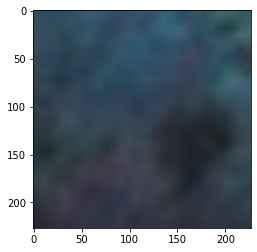

In [10]:
plt.imshow(trn_ds[0][600][0])
plt.show()

for i in range(N_folds):
    print(len(trn_ds[i]))
    print(len(val_ds[i]))

Third, check out the number of garbage and non garbage classes

In [12]:
Ngarb = 0
Nnongarb = 0
for i in range(N_folds):
     for j in notebook.tnrange(208000, desc="trn_ds"):
          if trn_ds[i][j][1] == 1:
               Ngarb += 1

          if trn_ds[i][j][1] == 0:
               Nnongarb += 1

     for j in notebook.tnrange(52000, desc="val_ds"):
          if val_ds[i][j][1] == 1:
               Ngarb += 1

          if val_ds[i][j][1] == 0:
               Nnongarb += 1

print(Ngarb)
print(Nnongarb)

trn_ds:   0%|          | 0/208000 [00:00<?, ?it/s]

val_ds:   0%|          | 0/52000 [00:00<?, ?it/s]

trn_ds:   0%|          | 0/208000 [00:00<?, ?it/s]

val_ds:   0%|          | 0/52000 [00:00<?, ?it/s]

trn_ds:   0%|          | 0/208000 [00:00<?, ?it/s]

val_ds:   0%|          | 0/52000 [00:00<?, ?it/s]

trn_ds:   0%|          | 0/208000 [00:00<?, ?it/s]

val_ds:   0%|          | 0/52000 [00:00<?, ?it/s]

trn_ds:   0%|          | 0/208000 [00:00<?, ?it/s]

val_ds:   0%|          | 0/52000 [00:00<?, ?it/s]

650000
650000


We have 260.000 patches and with a batch size of 100 this gives us 2.600 batch iterations for 1 epoch. Each epoch takes 1.700 secs to complete, so if we run 60 of them it would take 1.700 minutes = 28 hours to complete. We subdivide the 60 epochs into 5 folds of 12 epochs each.

In [13]:
for fold in range(N_folds):
    for ex in range(n_epochs):
        N = len(trn_dl[fold])
        train_epoch_losses = []
        for bx, data in enumerate(trn_dl[fold]):
            loss, acc = train_batch(alexnet, data, optimizer, criterion)
            train_epoch_losses.append(loss) 
            log.record(ex + (bx + 1)/N, trn_loss=loss, trn_acc=acc, end="\r")
            
        N = len(val_dl[fold])
        val_epoch_losses = []
        for bx, data in enumerate(val_dl[fold]):
            loss, acc = validate_batch(alexnet, data, criterion)
            val_epoch_losses.append(loss) 
            log.record(ex + (bx + 1)/N, val_loss=loss, val_acc=acc, end='\r')
  
        torch.save(alexnet, DATA_PATH + "alexnet_" + str(fold) + "_" + str(ex) + ".pth")
        torch.save(train_epoch_losses, DATA_PATH + "train_epoch_losses_" + str(fold) + "_" + str(ex) + ".pt")
        torch.save(val_epoch_losses, DATA_PATH + "val_epoch_losses_" + str(fold) + "_" + str(ex) + ".pt")

        scheduler.step()
        log.report_avgs(ex+1)
   
print("Training complete")

EPOCH: 1.000	trn_loss: 0.311	trn_acc: 0.867	val_loss: 0.211	val_acc: 0.915	(5133.71s - 302888.77s remaining)
EPOCH: 2.000	trn_loss: 0.216	trn_acc: 0.912	val_loss: 0.144	val_acc: 0.946	(6507.47s - 188716.69s remaining)
EPOCH: 3.000	trn_loss: 0.171	trn_acc: 0.933	val_loss: 0.120	val_acc: 0.959	(7785.39s - 147922.36s remaining)
EPOCH: 4.000	trn_loss: 0.157	trn_acc: 0.939	val_loss: 0.109	val_acc: 0.963	(9021.61s - 126302.53s remaining)
EPOCH: 5.000	trn_loss: 0.146	trn_acc: 0.944	val_loss: 0.104	val_acc: 0.964	(10257.19s - 112829.07s remaining)
EPOCH: 6.000	trn_loss: 0.143	trn_acc: 0.945	val_loss: 0.102	val_acc: 0.965	(11501.77s - 103515.96s remaining)
EPOCH: 7.000	trn_loss: 0.140	trn_acc: 0.946	val_loss: 0.100	val_acc: 0.966	(12756.89s - 96587.87s remaining)
EPOCH: 8.000	trn_loss: 0.140	trn_acc: 0.946	val_loss: 0.100	val_acc: 0.966	(14017.93s - 91116.52s remaining)
EPOCH: 9.000	trn_loss: 0.140	trn_acc: 0.947	val_loss: 0.099	val_acc: 0.967	(15270.15s - 86530.85s remaining)
EPOCH: 10.000	trn